# 🎬 Movie Tags Extraction with LDA Model
> This notebook performs an exploratory analysis to a Netflix movies and TV-shows dataset and applies the LDA model to extract the topic words from a given category of movie descriptions. 

- toc: true
- branch: master
- badges: true
- comments: true
- author: Shawn Shisen Yue
- categories: [fastpages, jupyter]

## Introduction 
***
If you are a movie fan, you might notice that in most movie recommendation websites, apart from the category the movie is classified in, there's usually some descriptive tags attached to each movie. The tags can describe the character in the movie, such as *The Dark Knight* which has the **"superhero"** tag, or an element in the movie, like the tag **"dinosaur"** on *Jurassic World*. Sometimes, the tag could even be the name of a movie star, such as **"Leonardo"** on *Titanic*. From a perspective of a movie fan, it's undoubtedly that these tags display the attractive points of the movie more vividly than the tedious classifications "Classic movies" and "Action movies". Therefore, people began to extract tags from the content of the films, utilizing machine learning and natural language processing methods. 

This project is aimed to explore a Netflix movies dataset, to gain some **insights** about **movie industry** and make an attempt to extract some tags from the **movie descriptions**. 

## Methods
***
### Dataset Introduction
This notebook includes a movie dataset from <https://www.kaggle.com/datasets/shivamb/netflix-shows>, which consists of listings of all the **movies** and **TV-shows** available on **Netflix**, along with details such as - cast, directors, ratings, release year, duration, etc.

Specifically, here's the meaning of each column in the dataset:

    show_id: Unique ID for every Movie / Tv Show 
    type: Identifier - A Movie or TV Show
    title: Title of the Movie / Tv Show
    director: Director of the Movie
    cast: Actors involved in the movie / show
    country: Country where the movie / show was produced
    date_added: Date it was added on Netflix
    release_year: Actual Release year of the move / show
    rating: TV Rating of the movie / show
    duration: Total Duration - in minutes or number of seasons
    listed_in: Genere
    description: The summary description
    
### LDA model 
Latent Dirichlet allocation (LDA) is a widey used **topic-generating** model. The model can identify the representative topics underlying a **document collection** or a **corpus**. This model produces topics based on **bag-of-word feature**, that each document is represented as a vector, in which every word corresponds to an id and its **appearing frequency** in the document. When producing the topics, The model samples a document-specific multinomial distribution over topics from Dirichlet distribution, and samples the word in the document from the corresponding multinomial distribution. 

## 📊 Exploratory Analysis & Results
***

### 1. 🎥 Data Preprocessing

> Import the libraries

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import ipywidgets
import gensim
import re
import wordcloud
import altair

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models

> Import the dataset and create a dataframe for movies

In [2]:
df = pd.read_csv("data/netflix_titles.csv")
movies = df[df["type"]=="Movie"]
movies.index = range(len(movies))

> Column information

In [3]:
#hide_input
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6131 non-null   object
 1   type          6131 non-null   object
 2   title         6131 non-null   object
 3   director      5943 non-null   object
 4   cast          5656 non-null   object
 5   country       5691 non-null   object
 6   date_added    6131 non-null   object
 7   release_year  6131 non-null   int64 
 8   rating        6129 non-null   object
 9   duration      6128 non-null   object
 10  listed_in     6131 non-null   object
 11  description   6131 non-null   object
dtypes: int64(1), object(11)
memory usage: 574.9+ KB


> Missing values visualization

<AxesSubplot:>

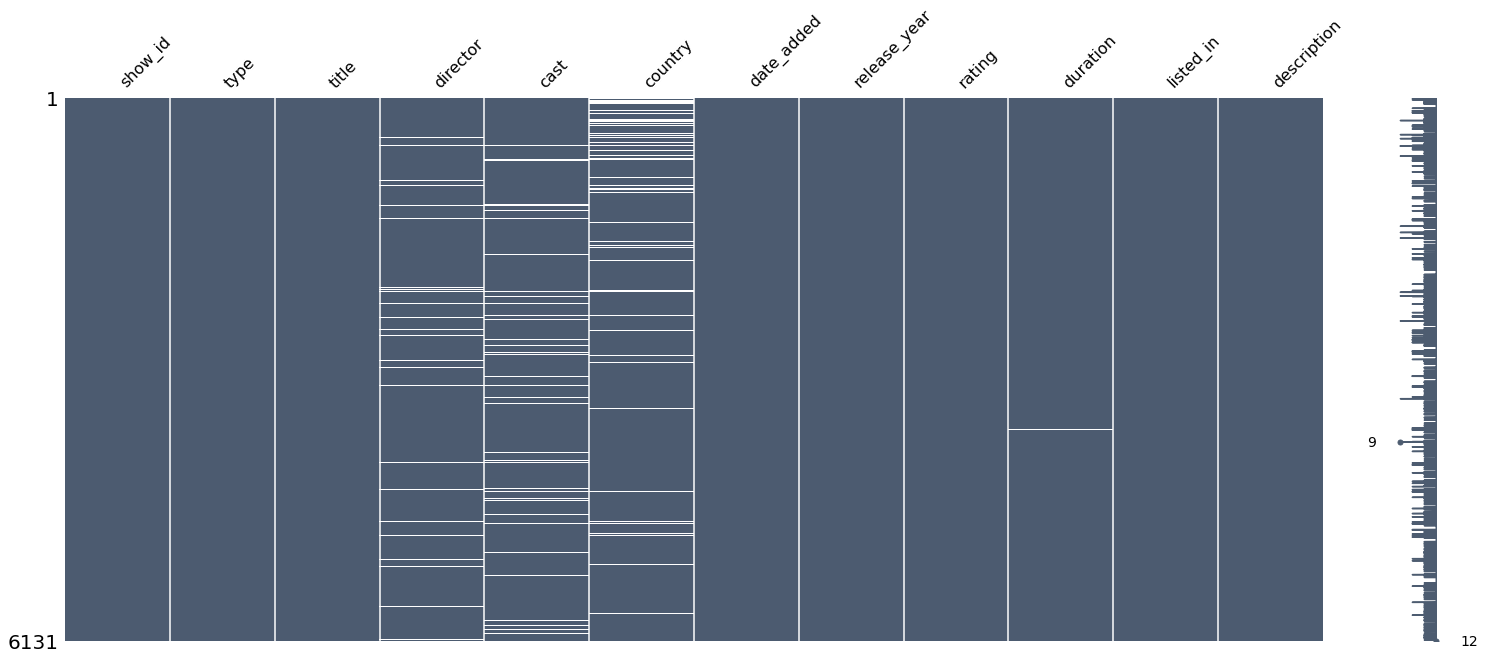

In [4]:
#hide_input
# Visualize the missing values in the dataframe.

import missingno as msno
msno.matrix(movies,color=(0.3,0.36,0.44))

**🍿️Comment**: 
- The missing values are distributed in columns **"director"**, **"cast"**, **"country"** and **"duration"**. 

> Sample rows

In [5]:
#hide_input
# Display several rows in the dataframe.

movies.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
2954,s4611,Movie,Udaan,Vikramaditya Motwane,"Rajat Barmecha, Ronit Roy, Ram Kapoor, Aayan B...",India,"October 1, 2018",2010,TV-MA,137 min,"Dramas, Independent Movies, International Movies","Upon returning to his industrial hometown, a y..."
3486,s5444,Movie,1898: Our Last Men in the Philippines,Salvador Calvo,"Luis Tosar, Javier Gutiérrez, Álvaro Cervantes...",Spain,"June 2, 2017",2016,R,130 min,"Dramas, International Movies","While Spain relinquishes its last colonies, a ..."
4987,s7381,Movie,Mahabharat,Amaan Khan,"Amitabh Bachchan, Ajay Devgn, Vidya Balan, Sha...",India,"August 1, 2018",2013,TV-14,119 min,"Action & Adventure, Dramas, International Movies",Two young brothers encounter a singing bird wh...
5899,s8525,Movie,The Surrounding Game,"Will Lockhart, Cole D. Pruitt",NaN,United States,"August 30, 2018",2018,TV-14,98 min,Documentaries,Teens in America dedicate themselves to the As...
1216,s1864,Movie,Hunterrr,Harshavardhan Kulkarni,"Gulshan Devaiah, Radhika Apte, Sai Tamhankar, ...",India,"October 12, 2020",2015,TV-MA,140 min,"Comedies, International Movies, Romantic Movies",A sex-obsessed young man tries to put his past...


**🍿️Comment**: 
- Based on the information in these rows, I converted the values in "duration" column into integers and the values in "date_added" column into date, to prepare them for plotting in the next section. 

In [6]:
#hide
for i in range(len(movies)):
    if type(movies.loc[i,'duration']) == str:
        movies.loc[i,'duration'] = int(movies.loc[i,'duration'].replace(' min', ''))

In [7]:
#hide
movies.sample()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4029,s6155,Movie,An American Tail: The Treasures of Manhattan I...,Larry Latham,"Thomas Dekker, Dom DeLuise, Pat Musick, Nehemi...",United States,"April 1, 2018",2000,G,79,Children & Family Movies,When Fievel and friends go hunting for buried ...


In [8]:
#hide
pd.to_datetime(movies['date_added'])

0      2021-09-25
1      2021-09-24
2      2021-09-24
3      2021-09-24
4      2021-09-23
          ...    
6126   2016-03-09
6127   2019-11-20
6128   2019-11-01
6129   2020-01-11
6130   2019-03-02
Name: date_added, Length: 6131, dtype: datetime64[ns]

### 2. 📈Exploratory Analysis

### Visualization 1

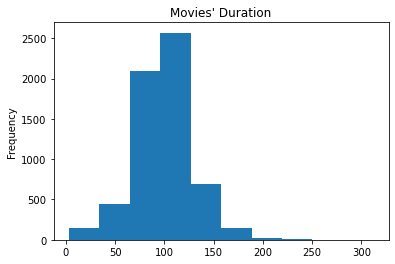

In [9]:
#hide_input
movies['duration'].plot(kind = 'hist')
plt.title("Movies' Duration")
plt.show()

**🍿️Comment**: 
- The histogram shows that most movies on Netflix are about 100 minutes. The longest movie contained in this dataframe is about to reach 300 minutes, nearly 5 hours.

### Visualization 2

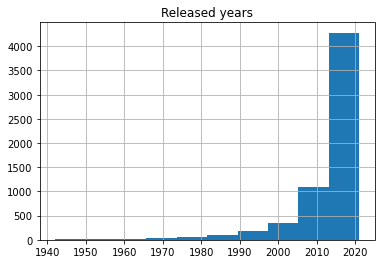

In [10]:
#hide_input
movies['release_year'].hist(xlabelsize = 10)
plt.title("Released years")
plt.show()

**🍿️Comment**: 
- Most movies included in the dataframe are released in recent 10 years.

### Visualization 3

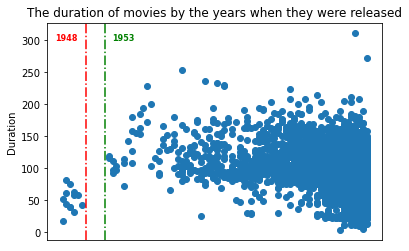

In [11]:
#hide_input
fig,ax = plt.subplots()
ax.scatter(movies['release_year'], movies['duration'])
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Duration')
ax.set_title('The duration of movies by the years when they were released')
plt.axvline(1948,c='r',ls='-.')
plt.axvline(1953,c='g',ls='-.')
plt.annotate('1948', xy=(1948, 300), xytext=(1940, 300),
            weight='bold', color='red',fontsize=8)
plt.annotate('1953', xy=(1953, 300), xytext=(1955, 300),
            weight='bold', color='green',fontsize=8)
plt.show()

**🍿️Comments**: 
- There's blank area between 1948 and 1953.
- The duration of all movies shot before 1948 are below 100 minutes.
- There's an increase of movies duration after 1953, that most movies' duration surpass 100 minutes and the longest one even reaches 200 minutes. 
- The short movies didn't quit the stage. In recent 10 years, there are still many movies with the duration below 50 minutes. 

### Visualization 4

In [17]:
#hide
movies = movies.rename(columns={"country":"country_or_region"})
movies.sample()

,show_id,type,title,director,cast,country_or_region,date_added,release_year,rating,duration,listed_in,description
6120,s8792,Movie,Young Adult,Jason Reitman,"Charlize Theron, Patton Oswalt, Patrick Wilson...",United States,"November 20, 2019",2011,R,94,"Comedies, Dramas, Independent Movies",When a divorced writer gets a letter from an o...


In [18]:
#hide
# Create two list of movies to inlude the movies produced in mainland China and Hong Kong.

China_list = []
for i in range(6131):
    if "China" in movies['country_or_region'].astype(str).iloc[i]:
        China_list.append(i)
China = movies.iloc[China_list]
China.reset_index()

Hong_Kong_list = []
for i in range(6131):
    if "Hong Kong" in movies['country_or_region'].astype(str).iloc[i] and "China" not in movies['country_or_region'].astype(str).iloc[i]:
        Hong_Kong_list.append(i)
Hong_Kong = movies.iloc[Hong_Kong_list]
Hong_Kong.reset_index()

,index,show_id,type,title,director,cast,country_or_region,date_added,release_year,rating,duration,listed_in,description
0,97,s160,Movie,Love in a Puff,Pang Ho-cheung,"Miriam Chin Wah Yeung, Shawn Yue, Singh Hartih...",Hong Kong,"September 1, 2021",2010,TV-MA,103,"Comedies, Dramas, International Movies",When the Hong Kong government enacts a ban on ...
1,322,s487,Movie,Ratchet and Clank,"Jericca Cleland, Kevin Munroe","Paul Giamatti, John Goodman, Bella Thorne, Ros...","Hong Kong, Canada, United States","July 9, 2021",2016,PG,94,"Children & Family Movies, Comedies, Sci-Fi & F...",Affable alien Ratchet longs to be a Galactic R...
2,1013,s1550,Movie,The Professor and the Madman,Farhad Safinia,"Mel Gibson, Sean Penn, Natalie Dormer, Eddie M...","Ireland, France, Iceland, United States, Mexic...","December 15, 2020",2019,TV-14,125,"Dramas, Independent Movies",While working on the first Oxford English Dict...
3,1055,s1621,Movie,Peppermint,Pierre Morel,"Jennifer Garner, John Ortiz, John Gallagher Jr...","Hong Kong, United States","December 1, 2020",2018,R,102,Action & Adventure,"After her family is murdered, a mild-mannered ..."
4,1346,s2060,Movie,Adrift,Baltasar Kormákur,"Shailene Woodley, Sam Claflin, Jeffrey Thomas,...","Hong Kong, Iceland, United States","September 1, 2020",2018,PG-13,96,"Action & Adventure, Dramas, Romantic Movies",A young couple’s sailing adventure becomes a f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,5722,s8307,Movie,The Flying Guillotine,Meng Hua Ho,"Kuan Tai Chen, Feng Ku, Hung Wei, Wu Chi Liu, ...",Hong Kong,"July 28, 2018",1975,TV-MA,101,"Action & Adventure, Dramas, International Movies","In Qing-dynasty China, the emperor commands th..."
59,5805,s8410,Movie,The Mad Monk,Johnny To,"Stephen Chow, Maggie Cheung, Anthony Wong Chau...",Hong Kong,"August 16, 2018",1993,TV-14,85,"Comedies, International Movies, Sci-Fi & Fantasy","To avoid punishment for his misdeeds, an arrog..."
60,5934,s8570,Movie,The Young Vagabond,Sze Yu Lau,"Chia-Hui Liu, Wong Yu, Jason Pai Piao, Lung We...",Hong Kong,"August 16, 2018",1985,TV-14,85,"Action & Adventure, Comedies, International Mo...","To avenge his master, a wine-loving young man ..."
61,6055,s8712,Movie,Weeds on Fire,Chi Fat Chan,"Liu Kai Chi, Lam Yiu-sing, Tony Tsz-Tung Wu, P...",Hong Kong,"September 27, 2018",2016,TV-MA,95,"Dramas, Independent Movies, International Movies","In 1980s Hong Kong, a school principal forms a..."


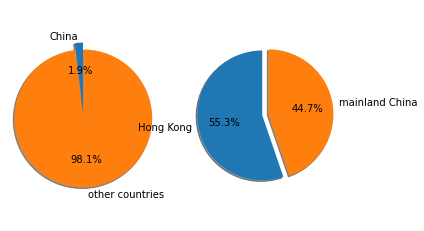

In [19]:
#hide_input
# Plot piecharts.

label1 = 'China', 'other countries'
label2 = 'Hong Kong', 'mainland China'
size1 = [114, 6017]
size2 = [63, 51]
explode = (0.1,0)  

fig, axs = plt.subplots(1, 2)
axs[0].pie(size1, explode=explode, labels=label1, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].pie(size2, explode=explode, labels=label2, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')
axs[1].axis('equal')
plt.show()

**🍿️Comment**: 
- Few films produced in mainland China are available on Netflix. The number of movies on Netflix produced in Hong Kong even surpasses that of mainland China.

### Visualization 5

In [20]:
#hide
# Create a dictionary to store the number of films each director shot. 

directors = {}
for i in range(len(movies)):
    if movies.loc[i,'director'] not in directors:
        directors[movies.loc[i,'director']] = 1
    else:
        directors[movies.loc[i,'director']] += 1

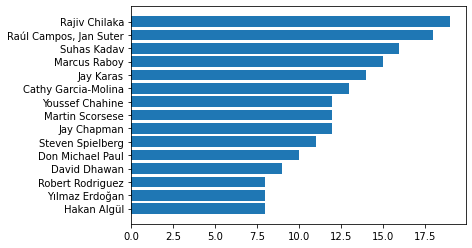

In [21]:
#hide_input
# Choose the top 15 directors according to the number of directors they produced in the dataframe. 

top_15_directors = sorted(directors.items(),key=lambda s:s[1],reverse=True)[1:16]
fig,ax = plt.subplots()
top_15 = [i[0] for i in top_15_directors]
movie_num = [j[1] for j in top_15_directors]
ax.barh(top_15,movie_num)
ax.invert_yaxis()
plt.show()

**🍿️Comment**: 
- There are many renowned directors such as "Christopher Nolan" and "Alfred Hitchcock" who have directed many well-known movies are not included, from which it's reasonable to infer that many popular movies aren't available on Netflix or they didn't be collected by this dataset. 

In [22]:
#hide
directors['Christopher Nolan']

1

### Visualization 6

In [23]:
#hide
# First create a list containing the names of categories.

categories = []
for i in range(len(movies)):
    for w in movies.loc[i,'listed_in'].split(", "):
        if w not in categories:
            categories.append(w)

In [24]:
#hide
# Create a list storing the number of movies in each category. 

NumberByTypes = []
for i in range(len(categories)):
    count = 0
    for x in range(len(movies)):
        if categories[i] in movies.loc[x,'listed_in'].split(", "):
            count += 1
    NumberByTypes.append(count)

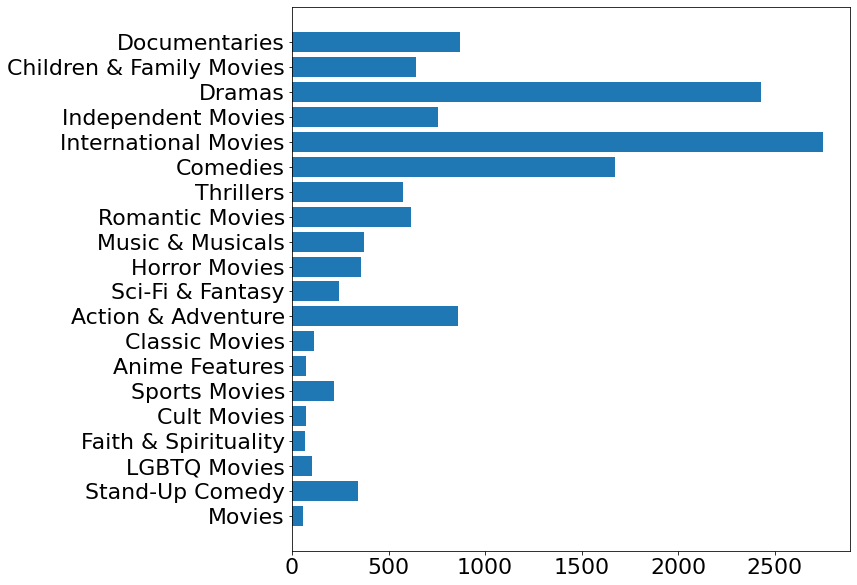

In [25]:
#hide_input
# Visualize the information.

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(categories,NumberByTypes)
ax.invert_yaxis()
plt.tick_params(labelsize=22)

**🍿️Comments**: 
- Apart from those movies that have been clearly categorized, there's a type named "Movies", which suggests that movies in this type are not categorized due to some reason. We will examine the content of these movies and determine how should they be classified.
- There aren't clear boundary between some of the categories, which means a movie can have multiple categories. The dim boundary may confuse the viewers and thus it's necessary to give these movies representative tags. 
- Through the names of some categories we can roughly predict the content of the movies. For instance, Faith & Spirituality movies may contain a lot of religious elements. This provides the possibility for the afterwards tag prediction task based on the descriptions of movies.

### 3. 🏷 Tags Extraction

In this section, I used **the LDA model** to analyze the descriptions of a certain category of movie and extract the keywords to represent the category. Specifically, I first used **nltk** to preprocess the description texts. Then I made a **dictionary** and a **corpus** for the tokenized and stemmed words. Finally, I used the LDA model to extract the keywords depending on appearing frequency and drew the **word cloud** graph to visualize the result. 

> Create a list to store the descriptions of movies from different categories

In [26]:
# Create a list to store the descriptions of movies from different categories. 

DescByTypes = []
for i in range(len(categories)):
    DescByTypes.append([movies.loc[x,'description'] for x in range(len(movies)) if categories[i] in movies.loc[x,'listed_in'].split(', ')])

> Create the list for documentary descriptions

In [27]:
# First try to predict some tags for Documentaries.

Documentaries = DescByTypes[0]

> Tokenize the document

In [28]:
# Create a list for tokenized words and remove those stop words.

myStopWords = list(punctuation) + stopwords.words('english')
Docu = []
for i in Documentaries:
    Docu.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])

> Stem the words

In [29]:
# Stem the words in this list.

p_stemmer = PorterStemmer()
Docu_stemmed = []
for i in Docu:
    Docu_stemmed.append([p_stemmer.stem(w) for w in i])

> Create a dictionary

In [30]:
# Create a dictionary for this document.

dictionary = corpora.Dictionary(Docu_stemmed)
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [31]:
#collapse-output
print(dictionary.token2id)

{'comic': 0, 'death': 1, 'end': 2, 'face': 3, 'father': 4, 'filmmak': 5, 'help': 6, 'life': 7, 'stage': 8, 'way': 9, 'becam': 10, 'close': 11, 'document': 12, 'escap': 13, 'hitler': 14, 'presid': 15, 'reveal': 16, 'spain': 17, 'world': 18, "'s": 19, 'big': 20, 'childhood': 21, 'dream': 22, 'live': 23, 'love': 24, 'rescu': 25, 'train': 26, 'archiv': 27, 'champion': 28, 'documentari': 29, 'footag': 30, 'interview': 31, 'intim': 32, 'michael': 33, 'portrait': 34, 'trace': 35, 'bond': 36, 'extraordinari': 37, 'ideal': 38, 'meet': 39, 'tragic': 40, 'captur': 41, 'killer': 42, 'mother': 43, 'polic': 44, 'two': 45, 'victim': 46, 'women': 47, 'work': 48, 'chart': 49, 'legendari': 50, 'man': 51, 'stori': 52, 'use': 53, 'american': 54, 'challeng': 55, 'chang': 56, 'continu': 57, 'health': 58, 'tradit': 59, 'win': 60, 'gener': 61, 'last': 62, 'peopl': 63, 'togeth': 64, 'cultur': 65, 'examin': 66, 'famili': 67, 'hip-hop': 68, 'perform': 69, 'race': 70, 'rap': 71, 'song': 72, 'violenc': 73, "''": 7

🍿️Comment:
- In this dictionary, each word corresponds to an unique number. 

> Make a corpus

In [32]:
# Make a corpus.

corpus = [dictionary.doc2bow(text) for text in Docu_stemmed]

> Establish the LDA model to extract keywords

In [33]:
# Train the lda model based on the dictionary and the corpus.

ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)

> Output

In [34]:
ldamodel.show_topics(num_topics=1)

[(0,
  '0.039*"documentari" + 0.030*"\'s" + 0.012*"life" + 0.010*"world" + 0.010*"explor" + 0.010*"follow" + 0.009*"``" + 0.009*"\'\'" + 0.009*"film" + 0.007*"stori"')]

**🍿Comment**: 
- The number in front of each word is measured based on the appearing frequency of the word in the document, and can be explained as the recommendation rate to choose the word as the topic word.  
- Some of the words such as "documentary", "explore", and "world" accurately reflect the content of this category, which proves the feasibility of this task.
- There are many punctuations and uninformative words involved in this list, so the next step is to add these strings to our stop words list to remove them from the dictionary. 

> Modify the stop words list

In [35]:
myStopWords.extend(["'s","'","·","``",'"','—'])

> Repeat the steps above

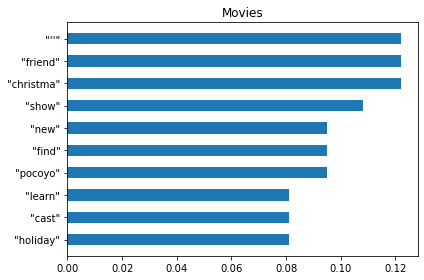

In [43]:
# Make an interactive visualization to reveal the predicted tags for each category.

Desc = []
for i in DescByTypes[19]:
    Desc.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])
p_stemmer = PorterStemmer()
Desc_stemmed = []
for i in Desc:
    Desc_stemmed.append([p_stemmer.stem(w) for w in i])
dictionary = corpora.Dictionary(Desc_stemmed)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in Desc_stemmed]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)
fig,ax = plt.subplots()

x = []
y = []
count = 0
for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
    if count % 2 == 0:
        y.insert(0,float(i))
    else:
        x.insert(0,i)
    count += 1
ax.barh(x,y,height=0.5)
ax.set_title(categories[19])
plt.tight_layout()
plt.show()

**🍿Comments**: 
- The tag words in most categories can accurately reflect the content of the movies invovled in that category, such as "gay", "love" and "teen" for LGBTQ movies, "murder", "mystery", "secret" and "killer" for Thrillers and "team", "player", "soccer" and "champion" for sports movies. 
- By adding those punctuations into myStopWords, there are mostly meaningful words in the graphs.
- The "Movies" category that was mentioned before might be some movies about holidays, because of the keywords "friend", "christma" and "holiday" in the chart.

> Visualize the output with wordcloud graph

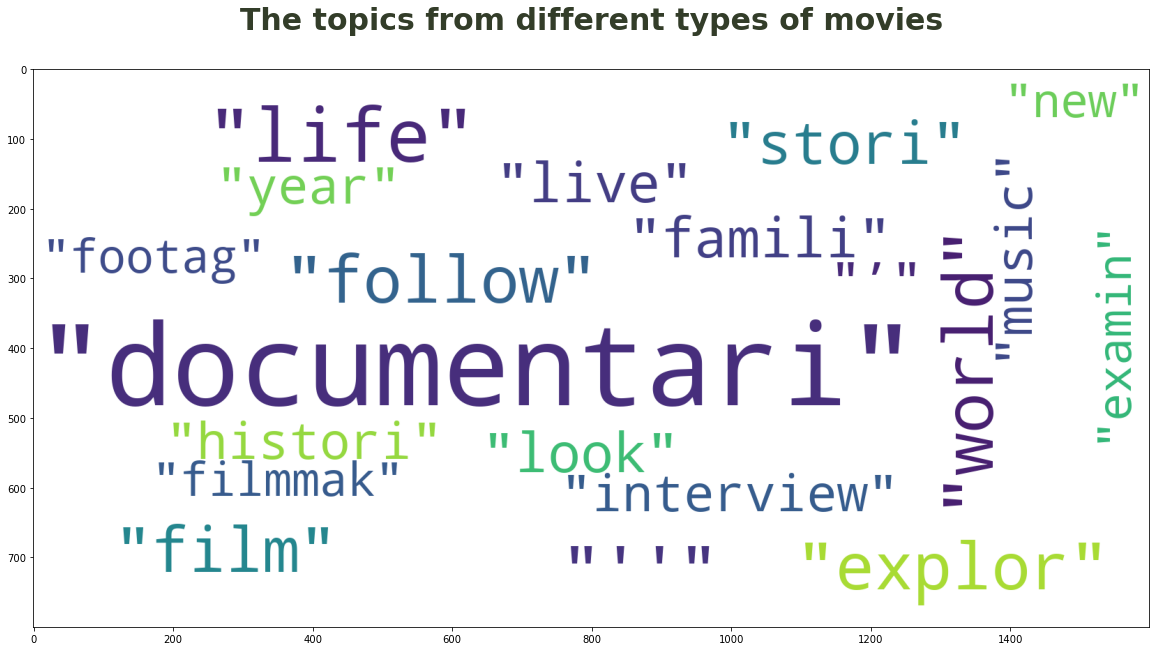

In [44]:
#hide_input
# Visualize the tag words through wordcloud. 


Desc = []
for i in DescByTypes[0]:
    Desc.append([w for w in word_tokenize(i.lower()) if w not in myStopWords])
p_stemmer = PorterStemmer()
Desc_stemmed = []
for i in Desc:
    Desc_stemmed.append([p_stemmer.stem(w) for w in i])
dictionary = corpora.Dictionary(Desc_stemmed)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in Desc_stemmed]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=1, 
                                           id2word = dictionary, 
                                           passes=5,
                                           random_state=1)

x = []
y = []
count = 0
for i in re.split(re.escape(' + ') + '|' + re.escape('*'), ldamodel.print_topics(num_topics=1, num_words=20)[0][1]):
    if count % 2 == 0:
        y.insert(0,float(i))
    else:
        x.insert(0,i)
    count += 1
plt.figure(figsize=(20,20))
frequencies = {}
for a in x:
    frequencies[a]=y[x.index(a)]
plt.title('The topics from different types of movies\n', fontsize=30, weight=600, color='#333d29')
wc = wordcloud.WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(x))
word_cloud = wc.generate_from_frequencies(frequencies)
plt.imshow(wc)
plt.show()

**🍿Comments**: 
- The wordcloud graph visualizes the outcome to a more readable form. Specifically, the size of the words appeared in the graph is aligned with their appearing frequency in the document. 
- Though there are still several meaningless marks and some of the words are not closely related to the category, there are a bunch of useful words that can generalize the movie category. 

**🌟A Little Idea**:
After I've done this, it occurs to me an interesting game, which is to use mainly the words provided in the graph to form a sentence related to that category. For instance, we form a sentence related to Documentaries with the words in this graph——"Documentaries are footages about people exploring the world and telling their stories".

## Conclusion
***
The project has successfully extracted tags from the corpus of a category of movies and has made the outcome visualized. Besides, the result manifests the **feasibility** to extract keywords from a set of short paragraphs that share some common features, so the methodology might be useful in the future to extract keywords from a set of **comments** with similarity in the **topic** and the **sentiment**. 

Movie tags extraction is a promising way to increase the popularity of underestimated movies, and enables more people to enjoy the fun of watching a film that fits their appetites in the holiday. With the rapid development of data science, I believe that in the near future, not only the movies, but also the classic novel, the operas and all other forms of art will be classified and stored in a more fine-grained way, which will make it easier for people to study on them, and dig out more interesting points about them. 

If you have any feedbacks or suggestions on how to improve my work, please let me know in the comments.

Thank you!